## 데이터 수집

In [ ]:
import googleapiclient.discovery
import pandas as pd
import isodate
from tqdm import tqdm
from googleapiclient.errors import HttpError

# YouTube API 서비스를 생성하는 함수
def get_youtube_service(api_key):
    return googleapiclient.discovery.build('youtube', 'v3', developerKey=api_key)

# 특정 비디오의 정보를 가져오는 함수
def get_video_info(youtube, video_id):
    try:
        request = youtube.videos().list(
            part='snippet,contentDetails',
            id=video_id,
            fields='items(id,snippet(title,channelId,channelTitle,publishedAt),contentDetails(duration))'
        )
        response = request.execute()
        return response['items'][0]
    except Exception as e:
        print(f"Error fetching video info for {video_id}: {e}")
        return None

# 특정 채널의 정보를 가져오는 함수
def get_channel_info(youtube, channel_id):
    try:
        request = youtube.channels().list(
            part='snippet,statistics',
            id=channel_id,
            fields='items(statistics(subscriberCount))'
        )
        response = request.execute()
        return response['items'][0]['statistics']
    except Exception as e:
        print(f"Error fetching channel info for {channel_id}: {e}")
        return None

# 채널 이름을 기반으로 채널 ID를 가져오는 함수
def get_channel_id_by_name(youtube, channel_name):
    try:
        request = youtube.search().list(
            part='snippet',
            q=channel_name,
            type='channel',
            fields='items(id(channelId),snippet(channelTitle))'
        )
        response = request.execute()
        return response['items'][0]['id']['channelId']
    except Exception as e:
        print(f"Error fetching channel ID for {channel_name}: {e}")
        return None

# 특정 채널의 비디오 ID를 가져오는 함수
def get_video_ids_from_channel(youtube, channel_id):
    video_ids = []
    page_token = None
    while True:
        try:
            request = youtube.search().list(
                part='id',
                channelId=channel_id,
                maxResults=50,
                pageToken=page_token,
                type='video'
            )
            response = request.execute()
            video_ids += [item['id']['videoId'] for item in response['items']]
            if 'nextPageToken' in response:
                page_token = response['nextPageToken']
            else:
                break
        except HttpError as e:
            print(f"Error fetching video IDs for channel {channel_id}: {e}")
            break
        except Exception as e:
            print(f"Error fetching video IDs for channel {channel_id}: {e}")
            break
    return video_ids

# 동영상의 댓글 정보를 가져오는 함수 (페이지네이션 적용)
def get_all_comments(youtube, video_id):
    comments = []
    page_token = None

    while True:
        try:
            request = youtube.commentThreads().list(
                part='snippet,replies',
                videoId=video_id,
                maxResults=100,
                pageToken=page_token
            )
            response = request.execute()

            for item in response['items']:
                try:
                    top_comment = item['snippet']['topLevelComment']['snippet']
                    comment = {
                        'comment_thread_id': item['id'],
                        'video_id': video_id,
                        'author_display_name': top_comment['authorDisplayName'],
                        'published_at': format_datetime(top_comment['publishedAt']),
                        'author_channel_id': top_comment['authorChannelId']['value'] if 'authorChannelId' in top_comment else None
                    }
                    comments.append(comment)

                    if 'replies' in item:
                        reply_count = item['snippet']['totalReplyCount']
                        if reply_count > 0:
                            reply_page_token = None
                            while True:
                                try:
                                    reply_request = youtube.comments().list(
                                        part='snippet',
                                        parentId=item['id'],
                                        maxResults=min(reply_count, 100),
                                        pageToken=reply_page_token
                                    )
                                    reply_response = reply_request.execute()

                                    for reply_item in reply_response['items']:
                                        try:
                                            reply_comment = {
                                                'comment_thread_id': reply_item['id'],
                                                'video_id': video_id,
                                                'author_display_name': reply_item['snippet']['authorDisplayName'],
                                                'published_at': format_datetime(reply_item['snippet']['publishedAt']),
                                                'author_channel_id': reply_item['snippet']['authorChannelId']['value'] if 'authorChannelId' in reply_item['snippet'] else None
                                            }
                                            comments.append(reply_comment)
                                        except KeyError as e:
                                            print(f"KeyError in processing reply: {e}")

                                    if 'nextPageToken' in reply_response:
                                        reply_page_token = reply_response['nextPageToken']
                                    else:
                                        break

                                except HttpError as e:
                                    print(f"Error fetching replies for comment {item['id']}: {e}")
                                    break

                                except Exception as e:
                                    print(f"Error fetching replies for comment {item['id']}: {e}")
                                    break

                except KeyError as e:
                    print(f"KeyError in processing comment: {e}")

            if 'nextPageToken' in response:
                page_token = response['nextPageToken']
            else:
                break

        except HttpError as e:
            print(f"Error fetching comments for video {video_id}: {e}")
            break

        except Exception as e:
            print(f"Error fetching comments for video {video_id}: {e}")
            break

    return comments

# 동영상 길이를 확인하여 short 비디오인지 여부를 판단하는 함수
def is_short(video_duration):
    try:
        duration = isodate.parse_duration(video_duration)
        return duration.total_seconds() <= 60
    except Exception as e:
        print(f"Error parsing duration: {e}")
        return False

# 날짜 및 시간을 지정된 형식으로 변환하는 함수
def format_datetime(datetime_str):
    try:
        return pd.to_datetime(datetime_str).strftime('%Y-%m-%dT%H:%M')
    except Exception as e:
        print(f"Error formatting datetime: {e}")
        return datetime_str

# 데이터 수집 함수
def collect_data(youtube, video_ids, start_index, end_index):
    combined_data = []
    selected_video_ids = video_ids[start_index:end_index]

    for video_id in tqdm(selected_video_ids, desc="Processing videos"):
        video_info = get_video_info(youtube, video_id)
        if video_info:
            channel_id = video_info['snippet']['channelId']
            channel_author = video_info['snippet']['channelTitle']
            title = video_info['snippet']['title']
            duration = video_info['contentDetails']['duration']
            upload_date = format_datetime(video_info['snippet']['publishedAt'])

            # 동영상 기본 정보 추가
            combined_data.append({
                'Channel_ID': channel_id,
                'Channel_Title': channel_author,
                'Video_ID': video_id,
                'Title': title,
                'Upload_Date': upload_date,
                'Comment_ID': None,
                'Comment_Author': None,
                'Is_Channel_Author': True,
                'Comment_Published_At': None,
                'Is_Short': is_short(duration)
            })

            # 댓글 데이터를 추가
            comments = get_all_comments(youtube, video_id)
            for comment in comments:
                combined_data.append({
                    'Channel_ID': channel_id,
                    'Channel_Title': channel_author,
                    'Video_ID': video_id,
                    'Title': title,
                    'Upload_Date': upload_date,
                    'Comment_ID': comment['comment_thread_id'],
                    'Comment_Author': comment['author_display_name'],
                    'Is_Channel_Author': (comment['author_channel_id'] == channel_id),
                    'Comment_Published_At': comment['published_at'],
                    'Is_Short': is_short(duration)
                })

    return combined_data

# 데이터 저장 함수
def save_data(data, file_name):
    try:
        df_combined = pd.DataFrame(data)
        df_combined.to_csv(f'{file_name}.csv', index=False)
        print("데이터를 저장했습니다.")
    except Exception as e:
        print(f"Error saving data: {e}")

# 메인 함수
def main():
    api_key = input("API 키를 입력하세요 (종료하려면 'done' 입력): ")
    if api_key.lower() == 'done':
        print("프로그램을 종료합니다.")
        return

    youtube = get_youtube_service(api_key)

    # 채널명을 입력받아 해당 채널의 비디오 ID를 가져옵니다.
    channel_name = input("채널명을 입력하세요: ")
    channel_id = get_channel_id_by_name(youtube, channel_name)
    if not channel_id:
        print(f"채널 '{channel_name}'을 찾을 수 없습니다.")
        return

    video_ids = get_video_ids_from_channel(youtube, channel_id)
    print(f"채널 '{channel_name}'에서 {len(video_ids)}개의 비디오를 찾았습니다.")

    start_index = int(input("비디오 ID를 가져올 시작 인덱스를 입력하세요 (0부터 시작): "))
    end_index = int(input("비디오 ID를 가져올 끝 인덱스를 입력하세요 (마지막 비디오 ID는 포함되지 않음): "))

    file_name = input("저장할 파일명을 입력하세요 (확장자 제외): ")

    if not file_name:
        print("파일명은 필수 입력 사항입니다.")
        return

    data = collect_data(youtube, video_ids, start_index, end_index)
    save_data(data, file_name)

if __name__ == "__main__":
    main()

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("Test_5개채널.csv")

In [3]:
df.Channel_Title.unique()

array(['오늘 해볼 미션은', '코리너즈Koreigners', '김뭉먕', '슈뢰딩거의고양이', '탱로그'],
      dtype=object)

In [4]:
len(df.Channel_Title.unique())

5

In [5]:
df

,Channel_ID,Channel_Title,Video_ID,Title,Upload_Date,Comment_ID,Comment_Author,Is_Channel_Author,Comment_Published_At,Is_Short
0,UCQKHgy2nQmBmInBYl60o11Q,오늘 해볼 미션은,9ela5b6YKT8,첫 번째 살아남기 미션 (2편),2024-07-14T05:00,NaN,NaN,True,NaN,True
1,UCQKHgy2nQmBmInBYl60o11Q,오늘 해볼 미션은,9ela5b6YKT8,첫 번째 살아남기 미션 (2편),2024-07-14T05:00,UgxkeC1m6v5OnUA0mXx4AaABAg,@sierrahoteloscar1920,False,2024-07-25T00:37,True
2,UCQKHgy2nQmBmInBYl60o11Q,오늘 해볼 미션은,9ela5b6YKT8,첫 번째 살아남기 미션 (2편),2024-07-14T05:00,UgyVWoPpiSGG2m9-6QF4AaABAg,@user-nn6yx2yx4k,False,2024-07-24T18:32,True
3,UCQKHgy2nQmBmInBYl60o11Q,오늘 해볼 미션은,9ela5b6YKT8,첫 번째 살아남기 미션 (2편),2024-07-14T05:00,Ugz1An4hjz37cdduEuB4AaABAg,@I_am-no_name1,False,2024-07-24T13:50,True
4,UCQKHgy2nQmBmInBYl60o11Q,오늘 해볼 미션은,9ela5b6YKT8,첫 번째 살아남기 미션 (2편),2024-07-14T05:00,Ugyq0BD2CY8m4EWfpwh4AaABAg,@the-god-of-mischief,False,2024-07-24T12:50,True
...,...,...,...,...,...,...,...,...,...,...
67884,UCWyzCP5a_x9M4p0yzedpZMw,탱로그,S6gDdBp-7jc,세 번째 라이브,2024-02-24T15:21,UgyfMv5OiJfm8NtIqaF4AaABAg,@sunkim9757,False,2024-02-24T15:52,False
67885,UCWyzCP5a_x9M4p0yzedpZMw,탱로그,S6gDdBp-7jc,세 번째 라이브,2024-02-24T15:21,UgyD_6yvoeybXg0xJgh4AaABAg,@minddang2,False,2024-02-24T15:45,False
67886,UCWyzCP5a_x9M4p0yzedpZMw,탱로그,S6gDdBp-7jc,세 번째 라이브,2024-02-24T15:21,UgxCIEIfJ4M_gLn2Hvd4AaABAg,@LightEaterASMR,False,2024-02-24T15:28,False
67887,UCWyzCP5a_x9M4p0yzedpZMw,탱로그,S6gDdBp-7jc,세 번째 라이브,2024-02-24T15:21,UgzsWMmKbjALb8I7Pet4AaABAg,@jazziseverywhere,False,2024-02-24T15:21,False


## 전처리

In [6]:
import pandas as pd

# 원본 데이터프레임을 복사하여 사용합니다.
data = df.copy()

# 필요한 컬럼만 추출합니다.
columns_to_use = [
    'Channel_ID', 'Channel_Title',
    'Video_ID', 'Title', 'Upload_Date', 'Is_Short',
    'Comment_ID', 'Comment_Published_At', 'Comment_Author', 'Is_Channel_Author'
]
data = data[columns_to_use]

# 'Is_Short' 값에 따라 데이터프레임을 나누어 복사합니다.
data1 = data[data['Is_Short'] == True].copy()  #쇼츠인 영상
data2 = data[data['Is_Short'] == False].copy() #쇼츠가 아닌 영상상

def processing1(data):
    # 'Upload_Date'와 'Comment_Published_At'을 datetime 형식으로 변환합니다.
    data['Upload_Date'] = pd.to_datetime(data['Upload_Date'])
    data['Comment_Published_At'] = pd.to_datetime(data['Comment_Published_At'])
    
    # 댓글 ID 기준 결측치를 제거합니다.
    data = data.dropna(subset=['Comment_ID'])
    
    # 댓글 ID 기준 중복을 제거합니다.
    data = data.drop_duplicates(subset=['Comment_ID'])
    
    # 채널 주인의 댓글을 제외합니다.
    data_filtered = data[data['Is_Channel_Author'] != 1]
    
    # 영상별로 동일한 작성자의 댓글을 1개씩만 남깁니다.
    data = data_filtered.drop_duplicates(subset=['Video_ID', 'Comment_Author'])
    
    # 인덱스를 리셋합니다.
    data = data.reset_index(drop=True)
    
    # 남은 댓글 ID의 개수를 확인합니다.
    remaining_comment_count = data['Comment_ID'].nunique()
    print(f"채널 주인의 댓글을 제외하고, 영상별로 작성자의 댓글을 1개씩만 남긴 후의 댓글 ID 개수는 {remaining_comment_count}개 입니다.")

        # 필요한 컬럼만 추출
    columns_to_use = [
        'Channel_ID', 'Channel_Title', 'Upload_Date', 'Comment_Published_At', 
        'Video_ID', 'Comment_ID'
    ]
    data = data[columns_to_use].copy()  # 명시적으로 사본을 만듭니다.
    
    # 날짜 형식에서 년-월-일 정보만 추출
    data['Upload_Date'] = data['Upload_Date'].astype(str).str[:10]
    data['Comment_Published_At'] = data['Comment_Published_At'].astype(str).str[:10]
    
    # 'Upload_Date'와 'Comment_Published_At'을 datetime 형식으로 변환 (년, 월, 일까지만)
    data['Upload_Date'] = pd.to_datetime(data['Upload_Date'], format='%Y-%m-%d', errors='coerce')
    data['Comment_Published_At'] = pd.to_datetime(data['Comment_Published_At'], format='%Y-%m-%d', errors='coerce')
    
    # 결과를 저장할 데이터프레임 생성
    df = pd.DataFrame()
    
    # 각 채널별로 처리
    try:
        for channel_id, channel_data in data.groupby('Channel_ID'):
            # 첫 업로드 날짜 찾기
            first_upload_date = channel_data['Upload_Date'].min()
    
            # 첫 업로드 날짜부터 현재까지의 월요일 기준 주 단위 날짜 생성
            date_range = pd.date_range(start=first_upload_date, end=channel_data['Upload_Date'].max() + pd.Timedelta(days=7), freq='W-MON')
    
            # 주간 데이터 저장 리스트 초기화
            weekly_data = []
    
            # 누적 값 초기화
            cumulative_videos = 0
            cumulative_comments = 0
    
            for i, week_start in enumerate(date_range):
                week_end = week_start + pd.Timedelta(days=7)
    
                # 현재 주의 비디오와 댓글 필터링
                weekly_videos = channel_data[(channel_data['Upload_Date'] >= week_start) & (channel_data['Upload_Date'] < week_end)]
                weekly_comments = channel_data[(channel_data['Comment_Published_At'] >= week_start) & (channel_data['Comment_Published_At'] < week_end)]
    
                # 고유 Comment_ID와 Comment_Published_At을 사용하여 누적 값 업데이트
                unique_comments = weekly_comments.drop_duplicates(subset=['Comment_ID', 'Comment_Published_At']).shape[0]
                cumulative_videos += weekly_videos['Video_ID'].nunique()
                cumulative_comments += unique_comments
    
                # 주간 데이터 추가
                weekly_data.append({
                    'Channel_ID': channel_id,
                    'Channel_Title': channel_data['Channel_Title'].iloc[0],
                    'Comment_Year': week_start.year,
                    'Comment_Week': week_start.isocalendar()[1],
                    'Cumulative_Videos': int(cumulative_videos),
                    'Cumulative_Comments': int(cumulative_comments),
                })
    
            # 현재 채널의 결과 데이터프레임 생성
            channel_df = pd.DataFrame(weekly_data)
    
            # 결과에 추가
            df = pd.concat([df, channel_df], ignore_index=True)
    except Exception as e:
        print(f"데이터 처리 중 오류 발생: {e}")
    
    # 'Cumulative_Videos'가 0인 행 제거
    if 'Cumulative_Videos' in df.columns:
        df = df[(df['Cumulative_Videos'] != 0)]
    else:
        print("'Cumulative_Videos' 열이 결과 데이터프레임에 존재하지 않습니다.")
    
    # 열 순서 정리
    expected_columns = ['Channel_ID', 'Channel_Title', 'Comment_Year', 'Comment_Week', 'Cumulative_Videos', 'Cumulative_Comments']
    missing_columns = [col for col in expected_columns if col not in df.columns]
    if missing_columns:
        print(f"다음 열이 결과 데이터프레임에 없습니다: {missing_columns}")
    else:
        df = df[expected_columns]

    # 누적 댓글 수를 누적 영상 수로 나누기
    df['Comments_Per_Video'] = df['Cumulative_Comments'] / df['Cumulative_Videos']
    df['Year_Week'] = df['Comment_Year'].astype(str) + '-' + df['Comment_Week'].astype(str)
    df = df.drop(['Channel_ID','Comment_Year','Comment_Week'],axis=1)
    
    return df

# 각 데이터프레임을 처리하고 결과를 저장합니다.
data1 = processing1(data1)
data2 = processing1(data2)


채널 주인의 댓글을 제외하고, 영상별로 작성자의 댓글을 1개씩만 남긴 후의 댓글 ID 개수는 33768개 입니다.
채널 주인의 댓글을 제외하고, 영상별로 작성자의 댓글을 1개씩만 남긴 후의 댓글 ID 개수는 23418개 입니다.


In [7]:
data1

,Channel_Title,Cumulative_Videos,Cumulative_Comments,Comments_Per_Video,Year_Week
0,김뭉먕,2,617,308.500000,2024-24
1,김뭉먕,5,2387,477.400000,2024-25
2,김뭉먕,7,4683,669.000000,2024-26
3,김뭉먕,8,5619,702.375000,2024-27
4,김뭉먕,9,6407,711.888889,2024-28
5,김뭉먕,11,7673,697.545455,2024-29
6,김뭉먕,12,8425,702.083333,2024-30
7,김뭉먕,12,8425,702.083333,2024-31
11,코리너즈Koreigners,3,21,7.000000,2024-18
12,코리너즈Koreigners,5,30,6.000000,2024-19


In [8]:
len(data1.Channel_Title.unique()) 
# 쇼츠 --> 쇼츠영상을 안올리거나 /6월20일 이후 영상을 올렸거나/ 쇼츠를 올렸지만 쇼츠올라온 모든 영상이 일주일 이내에 있으면 잡히지 않음

5

In [9]:
len(data2.Channel_Title.unique()) 
# 쇼츠아님 --> 영상을 안올리거나 /6월20일 이후 영상을 올렸거나/ 영상을 올렸지만 쇼츠올라온 모든 영상이 일주일 이내에 있으면 잡히지 않음

4

### 떡상 각도 확인하기(분석)-슬라이딩 윈도우 방식으로

In [10]:
import pandas as pd
from tqdm import tqdm
import numpy as np
from sklearn.linear_model import LinearRegression

# 슬라이딩 윈도우와 기울기 계산 함수
def calculate_slopes(data, periods):
    if not isinstance(periods, int):
        raise ValueError("`periods` must be an integer.")

    slopes = []
    channels = data['Channel_Title'].unique()

    # 단일 기간만 처리하는 경우
    for period in tqdm([periods], desc='Creating sliding windows and calculating slopes'):
        for channel in channels:
            channel_data = data[data['Channel_Title'] == channel]
            if len(channel_data) >= period:
                for i in range(len(channel_data) - period + 1):
                    window = channel_data.iloc[i:i+period]
                    comments_per_video = window['Comments_Per_Video'].values
                    year_week = window['Year_Week'].values[-1]  # 마지막 주차를 기간으로 사용

                    # x축 값 생성 (주차를 기준으로 0부터 시작)
                    x = np.arange(len(comments_per_video)).reshape(-1, 1)
                    y = comments_per_video

                    # 선형 회귀 모델을 사용하여 기울기 계산
                    model = LinearRegression().fit(x, y)
                    slope = model.coef_[0]  # 기울기

                    slopes.append({
                        'Channel_Title': channel,
                        'Period': period,
                        'Year_Week': year_week,
                        'Window': comments_per_video,
                        'Slope': slope
                    })
        print(f"Period {period}: {len(slopes)} slopes calculated")

    return pd.DataFrame(slopes)

# 채널 이름 리스트
Channel_name1= data1['Channel_Title'].unique()
Channel_name2= data2['Channel_Title'].unique()

# 기울기를 딕셔너리에 저장
slopes_dict = {}
slopes_list = []

# 기울기 계산 후 결과 처리 함수
def process_data1(df, video_type):
    Channel_name = df['Channel_Title'].unique()
    slopes_dict = {}
    slopes_list = []

    for channel in Channel_name1:
        channel_data = df[df['Channel_Title'] == channel]
        max_slope_row = channel_data[channel_data['Slope'] == channel_data['Slope'].max()]
        max_slope = max_slope_row['Slope'].values[0]
        max_year_week = max_slope_row['Year_Week'].values[0]
        slopes_dict[channel] = (max_slope, max_year_week)
        slopes_list.append(max_slope)
        
        print(f'{video_type}의 경우')
        print(f'{channel}의 가장 큰 기울기: {max_slope} (기간: {max_year_week})')
        
        if max_slope > 158.5:
            print(f'--> {channel}는 떡상 기준에 적합합니다! (기울기: {max_slope} > 158.5)')
            print('-------------------------------')
        else:
            print(f'--> {channel}는 떡상 기준에 부적합합니다! (기울기: {max_slope} < 158.5)')
            print('-------------------------------')

def process_data2(df, video_type):
    Channel_name = df['Channel_Title'].unique()
    slopes_dict = {}
    slopes_list = []

    for channel in Channel_name2:
        channel_data = df[df['Channel_Title'] == channel]
        max_slope_row = channel_data[channel_data['Slope'] == channel_data['Slope'].max()]
        max_slope = max_slope_row['Slope'].values[0]
        max_year_week = max_slope_row['Year_Week'].values[0]
        slopes_dict[channel] = (max_slope, max_year_week)
        slopes_list.append(max_slope)
        
        print(f'{video_type}의 경우')
        print(f'{channel}의 가장 큰 기울기: {max_slope} (기간: {max_year_week})')
    
        if max_slope > 238.18:
            print(f'--> {channel}는 떡상 기준에 적합합니다! (기울기: {max_slope} > 238.18)')
            print('-------------------------------')
        else : 
            print(f'--> {channel}는 떡상 기준에 부적합합니다! (기울기: {max_slope} < 238.18)')
            print('-------------------------------')



# 데이터 전처리된 데이터프레임을 사용하여 슬라이딩 윈도우와 기울기 계산
period = 2  # 슬라이딩 윈도우의 기간 (예시로 4주 설정)
data1_slopes = calculate_slopes(data1, period)
data2_slopes = calculate_slopes(data2, period)

# 긴 동영상과 쇼츠를 각각 처리
process_data1(data1_slopes, "쇼츠")
process_data2(data2_slopes, "긴 동영상")


Creating sliding windows and calculating slopes: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 25.78it/s]


Period 2: 39 slopes calculated


Creating sliding windows and calculating slopes: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 37.64it/s]

Period 2: 55 slopes calculated
쇼츠의 경우
김뭉먕의 가장 큰 기울기: 191.6 (기간: 2024-26)
--> 김뭉먕는 떡상 기준에 적합합니다! (기울기: 191.6 > 158.5)
-------------------------------
쇼츠의 경우
코리너즈Koreigners의 가장 큰 기울기: 125.95238095238089 (기간: 2024-27)
--> 코리너즈Koreigners는 떡상 기준에 부적합합니다! (기울기: 125.95238095238089 < 158.5)
-------------------------------
쇼츠의 경우
오늘 해볼 미션은의 가장 큰 기울기: 203.41666666666666 (기간: 2024-30)
--> 오늘 해볼 미션은는 떡상 기준에 적합합니다! (기울기: 203.41666666666666 > 158.5)
-------------------------------
쇼츠의 경우
탱로그의 가장 큰 기울기: 105.66666666666663 (기간: 2024-16)
--> 탱로그는 떡상 기준에 부적합합니다! (기울기: 105.66666666666663 < 158.5)
-------------------------------
쇼츠의 경우
슈뢰딩거의고양이의 가장 큰 기울기: 311.2857142857142 (기간: 2024-26)
--> 슈뢰딩거의고양이는 떡상 기준에 적합합니다! (기울기: 311.2857142857142 > 158.5)
-------------------------------
긴 동영상의 경우
김뭉먕의 가장 큰 기울기: 181.49999999999997 (기간: 2024-25)
--> 김뭉먕는 떡상 기준에 부적합합니다! (기울기: 181.49999999999997 < 238.18)
-------------------------------
긴 동영상의 경우
코리너즈Koreigners의 가장 큰 기울기: 322.99999999999994 (기간: 2024-28)
--> 코리너즈Korei

## 이동평균선 보기

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

def analyze_channel1(channel_name, df):
    # 한글 폰트 설정
    font_path = 'C:/Windows/Fonts/malgun.ttf'  # 윈도우의 경우
    font_name = font_manager.FontProperties(fname=font_path).get_name()
    rc('font', family=font_name)
    
    # 채널에 해당하는 데이터 필터링 및 복사본 생성
    df1 = df[df.Channel_Title == channel_name].copy()  # 원본 데이터프레임의 복사본을 사용
    df1 = df1.reset_index(drop=True)
    
    # 시계열 데이터 준비
    signal = df1['Comments_Per_Video']
    
    # 이동 평균 계산
    df1['4_Week_Moving_Avg'] = signal.rolling(window=4).mean() 
    df1['Weekly_Moving_Avg'] = signal.rolling(window=1).mean()  # 주당 이동 평균
    df1['3_Week_Moving_Avg'] = signal.rolling(window=3).mean()  # 3주 이동 평균

    # 변화율 계산
    df1['Pct_Change'] = signal.pct_change()
    
    # 모든 데이터를 포함한 필터링
    df1_filtered = df1.copy()
    
    # 분석 결과 시각화
    plt.figure(figsize=(12, 6))
    
    # 원본 데이터와 이동 평균 시각화
    plt.plot(df1_filtered['Year_Week'], df1_filtered['Comments_Per_Video'], label='Comments Per Video', marker='o')
    plt.plot(df1_filtered['Year_Week'], df1_filtered['4_Week_Moving_Avg'], label='4-Week Moving Average', linestyle='--')
    plt.plot(df1_filtered['Year_Week'], df1_filtered['Weekly_Moving_Avg'], label='Weekly Moving Average', linestyle='-.')
    plt.plot(df1_filtered['Year_Week'], df1_filtered['3_Week_Moving_Avg'], label='3-Week Moving Average', linestyle=':')
    
    plt.xlabel('Year-Week')
    plt.ylabel('Comments Per Video')
    plt.title(f'{channel_name}: Comments Per Video Analysis')
    plt.xticks(rotation=90)
    plt.legend()
    plt.grid()
    plt.show()

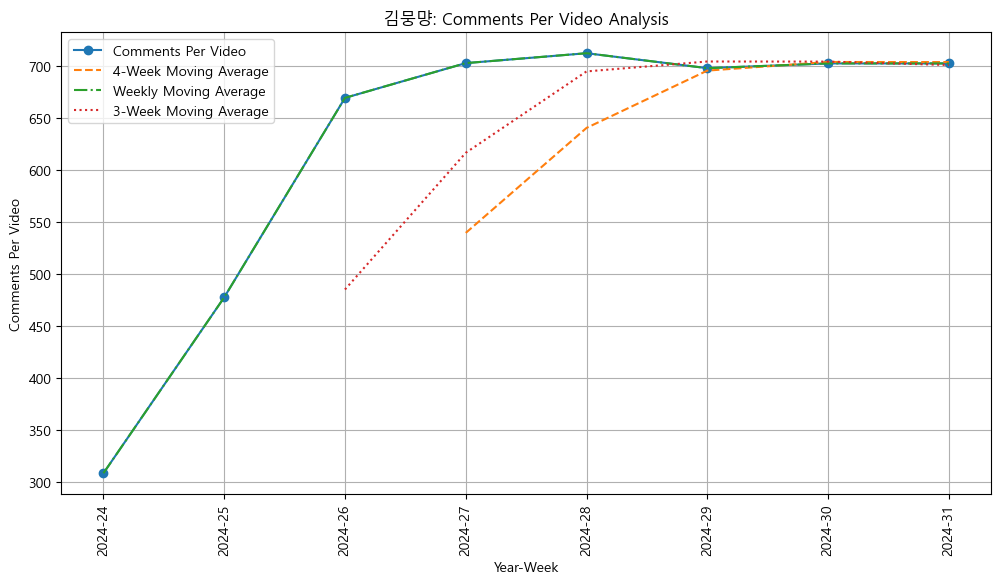

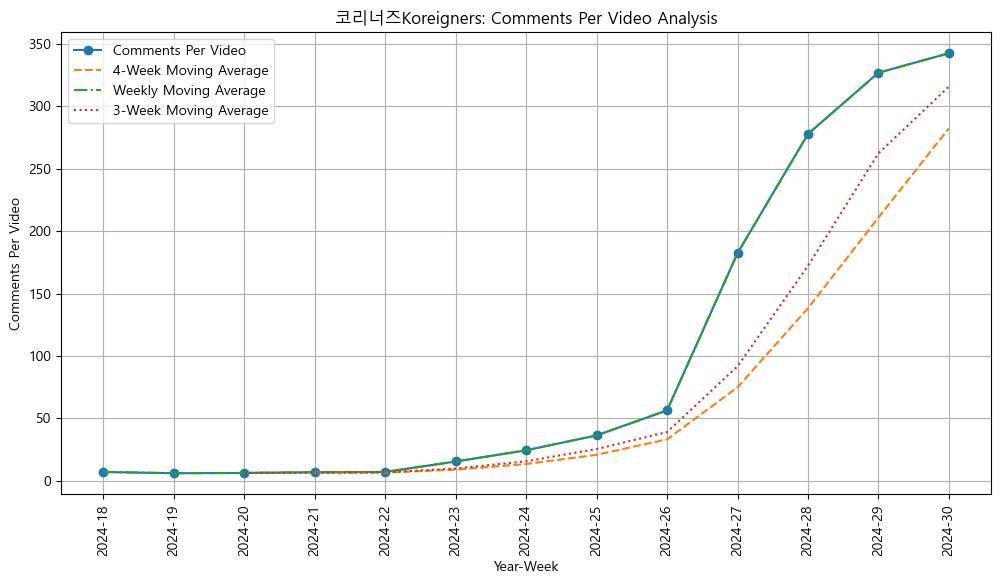

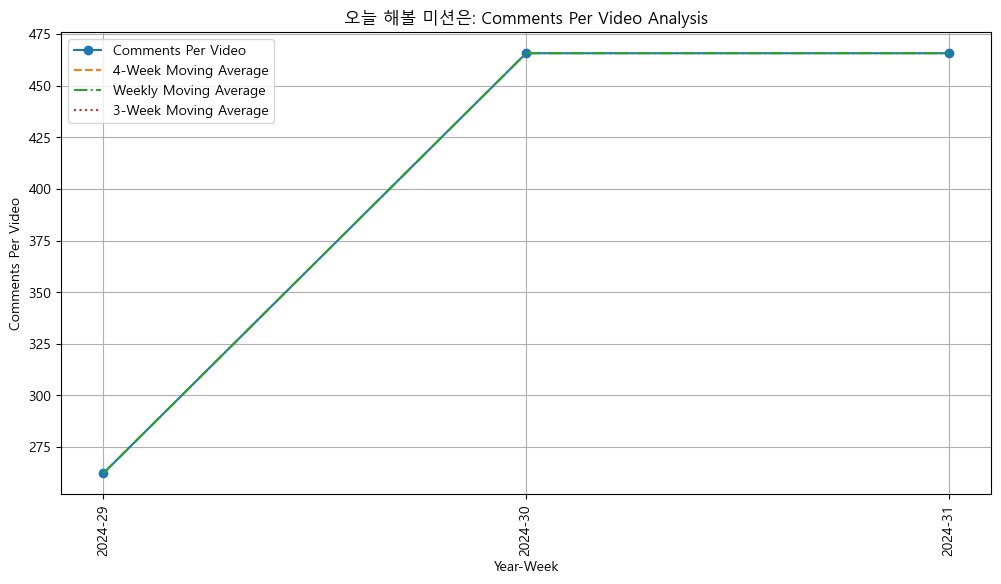

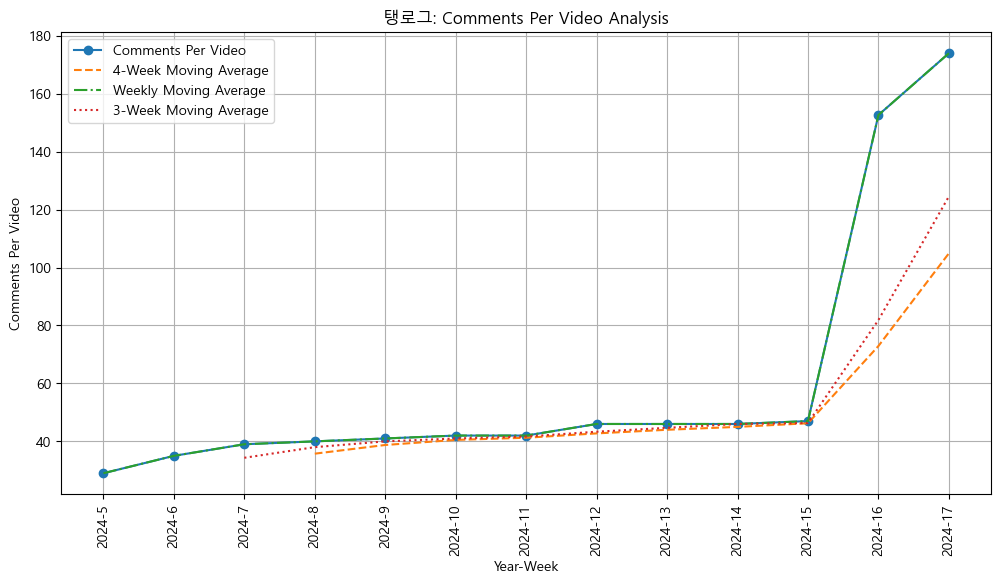

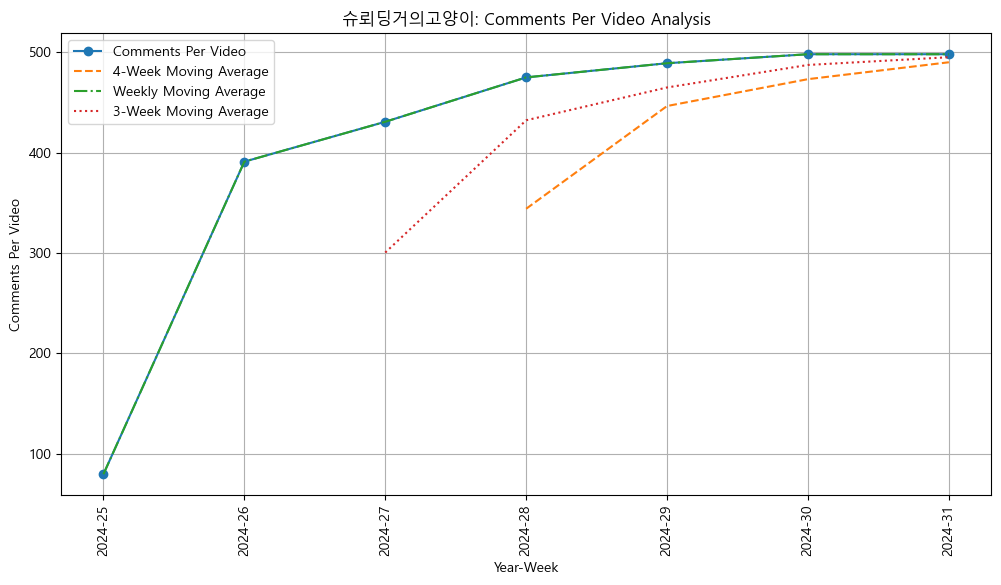

In [12]:
dc1 = data1.Channel_Title.unique()  #쇼츠

for i in dc1: # 쇼츠의 경우
    analyze_channel1(i,data1)

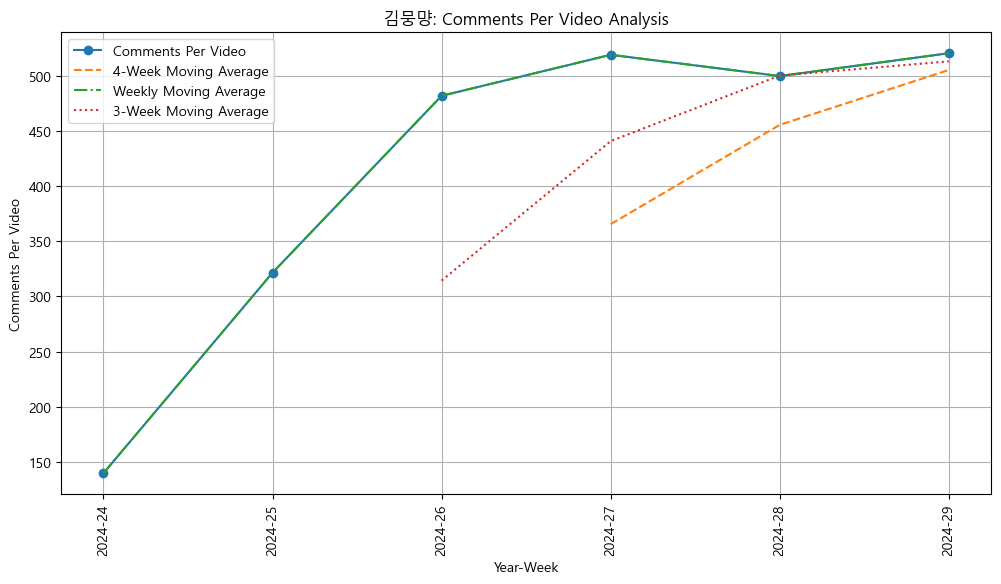

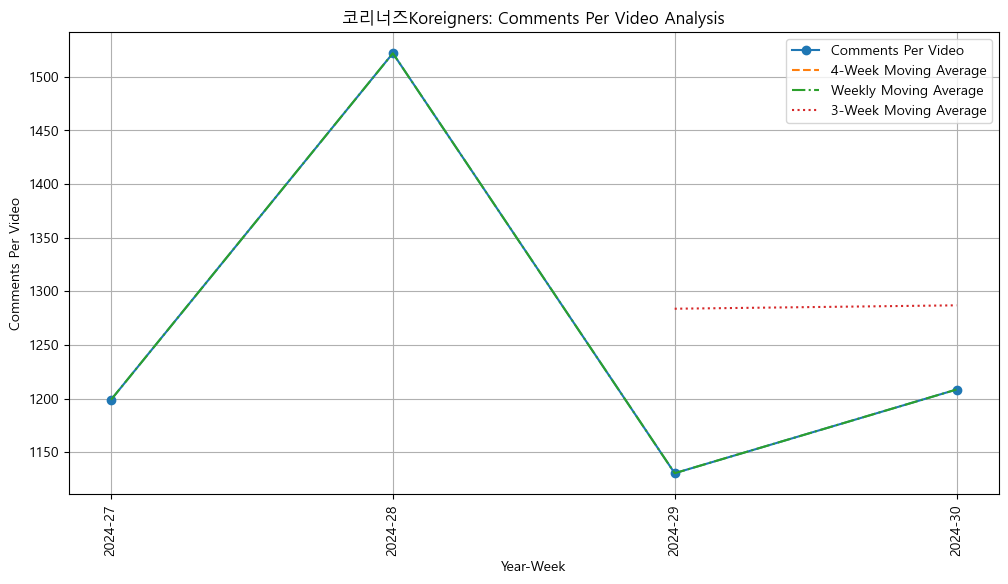

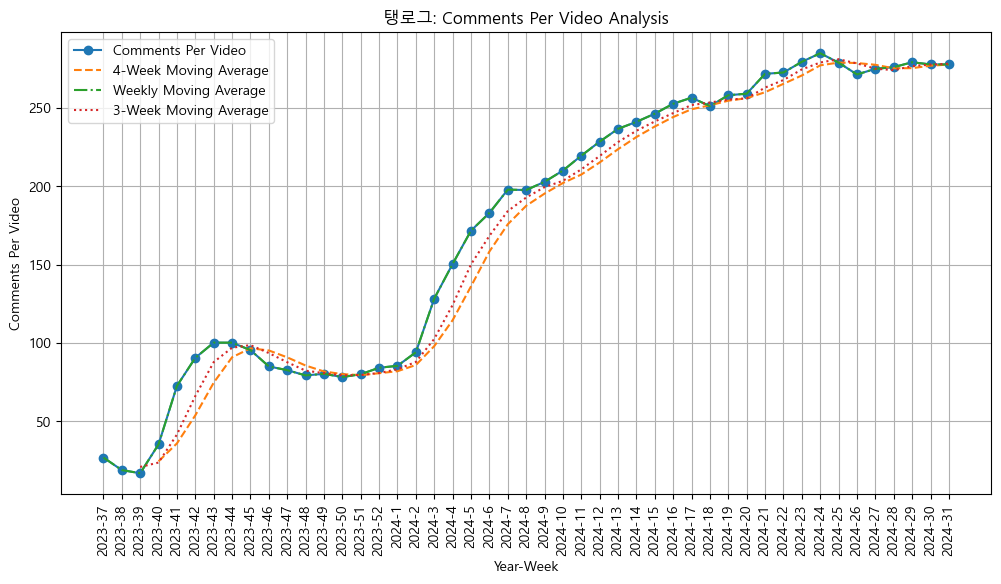

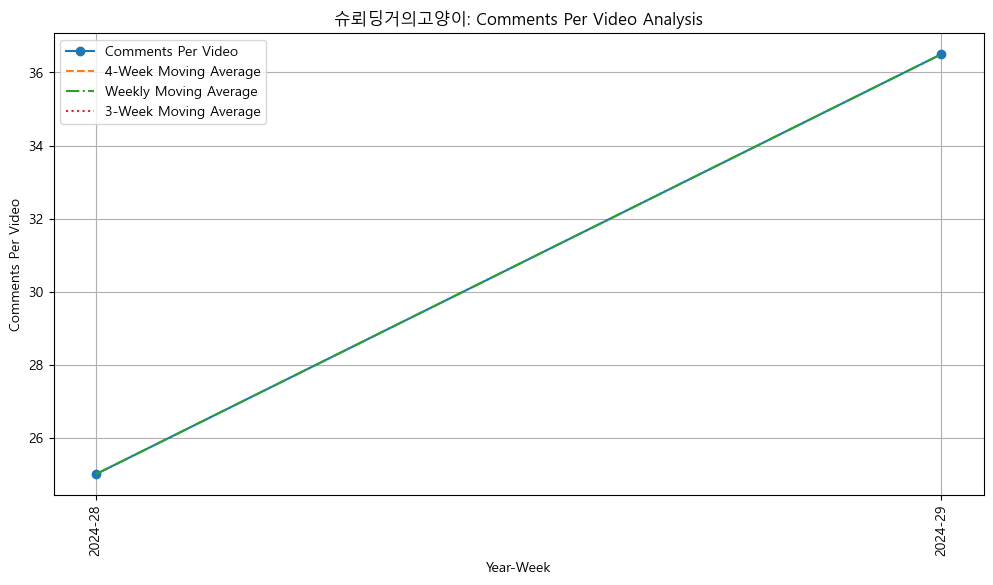

In [13]:
dc2 = data2.Channel_Title.unique()  #쇼츠 아님

for i in dc2: #쇼츠가 이닌 경우
    analyze_channel1(i,data2)